In [ ]:
pip install networkx matplotlib numpy scikit-learn qiskit-optimization gurobipy cplex docplex pennylane --quiet

In [ ]:
pip install qiskit==1.4.2

# Sampling
The MaxCut problem instances utilized in this analysis are sourced from the [HamLib](https://portal.nersc.gov/cfs/m888/dcamps/hamlib/) library. This collection encompasses a diverse range of graph topologies, including circulant graphs, bipartite graphs, $G_{n,p}$ random graphs, regular graphs and star graphs.

In [2]:
import zipfile
import requests
from io import BytesIO
import h5py
import networkx as nx
import numpy as np

url_circ = 'https://portal.nersc.gov/cfs/m888/dcamps/hamlib/binaryoptimization/maxcut/random/graphs/graph-circulant.zip'
url_bipart = 'https://portal.nersc.gov/cfs/m888/dcamps/hamlib/binaryoptimization/maxcut/random/graphs/graph-complete_bipart.zip'

url_gnp_k2 = 'https://portal.nersc.gov/cfs/m888/dcamps/hamlib/binaryoptimization/maxcut/random/graphs/graph-gnp_k-2.zip'
url_gnp_k3 = 'https://portal.nersc.gov/cfs/m888/dcamps/hamlib/binaryoptimization/maxcut/random/graphs/graph-gnp_k-3.zip'
url_gnp_k4 = 'https://portal.nersc.gov/cfs/m888/dcamps/hamlib/binaryoptimization/maxcut/random/graphs/graph-gnp_k-4.zip'
url_gnp_k5 = 'https://portal.nersc.gov/cfs/m888/dcamps/hamlib/binaryoptimization/maxcut/random/graphs/graph-gnp_k-5.zip'

url_reg_3 = 'https://portal.nersc.gov/cfs/m888/dcamps/hamlib/binaryoptimization/maxcut/random/graphs/graph-regular_reg-3.zip'
url_reg_4 = 'https://portal.nersc.gov/cfs/m888/dcamps/hamlib/binaryoptimization/maxcut/random/graphs/graph-regular_reg-4.zip'
url_reg_5 = 'https://portal.nersc.gov/cfs/m888/dcamps/hamlib/binaryoptimization/maxcut/random/graphs/graph-regular_reg-5.zip'
url_reg_6 = 'https://portal.nersc.gov/cfs/m888/dcamps/hamlib/binaryoptimization/maxcut/random/graphs/graph-regular_reg-6.zip'

url_star = 'https://portal.nersc.gov/cfs/m888/dcamps/hamlib/binaryoptimization/maxcut/random/graphs/graph-star.zip'

url = [url_circ, url_bipart, url_gnp_k2, url_gnp_k3, url_gnp_k4, url_gnp_k5, url_reg_3, url_reg_4, url_reg_5, url_reg_6, url_star]

## Sampling all graph types


In [3]:
import random

all_sampled_graphs = []

for graph_type in url:
    sampled_graphs = []
    r = requests.get(graph_type, stream=True)
    z = zipfile.ZipFile(BytesIO(r.content))
    hdf5_filename = z.namelist()[0]
    z.extract(hdf5_filename)

    with h5py.File(hdf5_filename, 'r') as f:
        dataset_keys = list(f.keys())
        num_datasets = len(dataset_keys)

        random_indices = random.sample(range(num_datasets), 5)

        for index in random_indices:
            graph = nx.Graph(list(np.array(f[dataset_keys[index]])))

            if graph.number_of_nodes() <= 250 and graph.number_of_nodes() >= 4:
                sampled_graphs.append(graph)

    all_sampled_graphs.append(sampled_graphs)

# 1. Classical Solvers WITHOUT Partitioning
The subsequent code block defines a function designed to calculate the value of the MaxCut for a given graph.

In [7]:
from qiskit_optimization.applications import Maxcut
from qiskit_optimization.problems import QuadraticProgram
from qiskit_optimization.algorithms import GurobiOptimizer
from qiskit_optimization.algorithms import GoemansWilliamsonOptimizer
from qiskit_optimization.algorithms import CplexOptimizer
import numpy as np
import networkx as nx


def classical_solvers_without_partitioning(graph):
    A = nx.to_numpy_array(graph)
    max_cut = Maxcut(A)
    qp = max_cut.to_quadratic_program()

    optimizer = GoemansWilliamsonOptimizer(2)
    gw_result = optimizer.solve(qp)
    gw_cut_edges = 0
    for u, v in graph.edges():
        if gw_result.x[u] != gw_result.x[v]:
            gw_cut_edges += 1
    print("GW Done")

    #nx_cut_size, partition = nx.approximation.one_exchange(graph, seed=1)
    #print("Nx Done")

    #optimizer = CplexOptimizer()
    #cplex_result = optimizer.solve(qp)
    #cplex_cut_edges = 0
    #for u, v in graph.edges():
    #    if cplex_result.x[u] != cplex_result.x[v]:
    #        cplex_cut_edges += 1
    #print("Cplex Done")

    #optimizer = GurobiOptimizer() if GurobiOptimizer.is_gurobi_installed() else None
    #gurobi_result = optimizer.solve(qp)
    #gurobi_cut_edges = 0
    #for u, v in graph.edges():
    #    if gurobi_result.x[u] != gurobi_result.x[v]:
    #        gurobi_cut_edges += 1
    #print("Gurobi Done")
    gurobi_cut_edges, cplex_cut_edges, nx_cut_size = 0, 0, 0

    return gurobi_cut_edges, gw_cut_edges, cplex_cut_edges, nx_cut_size

# 2. Classical Solvers WITH Partitioning

In our analysis, we use the scalability of classical solvers, which are not constrained by qubit limitations inherent in quantum systems. As such, we define partition target sizes as a function of the total node count in the graph. The three target sizes employed are midpoint (half of total nodes), lower quartile (quarter of total nodes) and upper quartile (three-quarters of total nodes). This range of target sizes is selected to effectively demonstrate the performance spectrum across various partition sizes.

In [8]:
from qiskit_optimization.problems import QuadraticProgram
from qiskit_optimization.algorithms import GurobiOptimizer
from qiskit_optimization.algorithms import GoemansWilliamsonOptimizer
from qiskit_optimization.algorithms import CplexOptimizer
import numpy as np
import networkx as nx
from sklearn.cluster import SpectralClustering

def cluster_graph(graph: nx.Graph, avg_partition_size=6.5) -> list[nx.Graph]:

    subgraphs = []
    n = len(graph.nodes())
    total_edges = 0
    no_of_clusters = int(n / avg_partition_size)

    if no_of_clusters < 1:
        no_of_clusters = 1
    adj_matrix = nx.to_numpy_array(graph)

    sc = SpectralClustering(n_clusters=no_of_clusters, affinity='precomputed')
    partition = sc.fit_predict(adj_matrix)

    for i in range(no_of_clusters):
        subgraph = graph.subgraph([node for node, cluster in enumerate(partition) if cluster == i])
        total_edges += subgraph.number_of_edges()
        subgraphs.append(subgraph)

    #print(f"ATTENTION: Total edges are fewer than the original graph {total_edges}")
    edges_after_pruning = total_edges / graph.number_of_edges()

    return subgraphs, edges_after_pruning

def get_solution_from_cut_edges(each, index_map, solutions, result):
    for node in each.nodes():
        index = index_map[node]
        if solutions[node] is None:
            solutions[node] = int(result[index])
        else:
            count_0 = solutions.count(0)
            count_1 = solutions.count(1)
            if (count_0 > count_1 and solutions[node] == 0) or \
              (count_1 > count_0 and solutions[node] == 1) or \
              (count_0 == count_1):
                solutions[node] = int(result[index])
    return solutions

def classical_solvers_with_partitioning(graph):
    mid = int(round(graph.number_of_nodes() / 2))
    low = int(round(graph.number_of_nodes() / 4))
    high = int(round((3*graph.number_of_nodes()) / 4))
    print(f"low: {low}, mid: {mid}, high: {high}")
    target_sizes = [low, mid, high]
    gurobi_cut_sizes = []
    gw_cut_sizes = []
    cplex_cut_sizes = []
    nx_cut_sizes = []
    edges_after_pruning = []

    for target_size in target_sizes:
        partitioning = cluster_graph(graph, target_size)
        subgraphs = partitioning[0]
        edges_after_pruning.append(partitioning[1])
        num_nodes = graph.number_of_nodes()
        solutions = [None] * num_nodes

        for each in subgraphs:
            print(each.nodes())
            index_map = {node: idx for idx, node in enumerate(each.nodes())}
            subgraph = nx.relabel_nodes(each, index_map)

            A = nx.to_numpy_array(subgraph)
            max_cut = Maxcut(A)
            qp = max_cut.to_quadratic_program()

            optimizer = GoemansWilliamsonOptimizer(2)
            gw_result = optimizer.solve(qp).x

            #optimizer = CplexOptimizer()
            cplex_result = gw_result  #optimizer.solve(qp).x

            #optimizer = GurobiOptimizer() if GurobiOptimizer.is_gurobi_installed() else None
            gurobi_result = gw_result   #optimizer.solve(qp).x

            #nx_cut_size, nx_result = nx.approximation.one_exchange(subgraph, seed=1)

            get_solution_from_cut_edges(each, index_map, solutions, gurobi_result)
            get_solution_from_cut_edges(each, index_map, solutions, gw_result)
            get_solution_from_cut_edges(each, index_map, solutions, cplex_result)
            #get_solution_from_cut_edges(each, index_map, solutions, nx_result)


        def evaluate_cut_size(solutions, graph):
            cut_edges = 0
            for u, v in graph.edges():
                if solutions[u] != solutions[v]:
                    cut_edges += 1
            return cut_edges

        gurobi_cut_sizes.append(evaluate_cut_size(solutions, graph))
        gw_cut_sizes.append(evaluate_cut_size(solutions, graph))
        cplex_cut_sizes.append(evaluate_cut_size(solutions, graph))
        #nx_cut_sizes.append(evaluate_cut_size(solutions, graph))

    return gurobi_cut_sizes, gw_cut_sizes, cplex_cut_sizes, nx_cut_sizes, edges_after_pruning

## Comparison of Classical Solvers with & w/o Partitioning

In [ ]:
# Run to collect results
results = {
    'problem_size': [],
    'gurobi_cut_sizes': [],
    'gw_cut_sizes': [],
    'cplex_cut_sizes': [],
    'part_gurobi_cut_sizes': [[], [], []],  # For different partition sizes
    'part_gw_cut_sizes': [[], [], []],
    'part_cplex_cut_sizes': [[], [], []],
    'edges_after_pruning': []
}

for lists in all_sampled_graphs:
    for graph in lists:
        size = graph.number_of_nodes()
        results['problem_size'].append(size)

        # Classical solvers with partitioning
        cut_sizes_with_part = classical_solvers_with_partitioning(graph)
        for i in range(3):  # Gurobi, GW, CPLEX
            results[f'part_{["gurobi", "gw", "cplex"][i]}_cut_sizes'][0].append(cut_sizes_with_part[i][0])
            results[f'part_{["gurobi", "gw", "cplex"][i]}_cut_sizes'][1].append(cut_sizes_with_part[i][1])
            results[f'part_{["gurobi", "gw", "cplex"][i]}_cut_sizes'][2].append(cut_sizes_with_part[i][2])
        results['edges_after_pruning'].extend(cut_sizes_with_part[4])

        # Classical solvers without partitioning
        cut_sizes_wo_part = classical_solvers_without_partitioning(graph)
        results['gurobi_cut_sizes'].append(cut_sizes_wo_part[0])
        results['gw_cut_sizes'].append(cut_sizes_wo_part[1])
        results['cplex_cut_sizes'].append(cut_sizes_wo_part[2])

# Split Results by Graph Type

In [11]:
graph_type_lengths = [len(graphs) for graphs in all_sampled_graphs]
cumulative_lengths = [sum(graph_type_lengths[:i+1]) for i in range(len(graph_type_lengths))]
start_indices = [0] + cumulative_lengths[:-1]
end_indices = cumulative_lengths

split_results = {
    'circulant': {},
    'bipartite': {},
    'gnp_k2': {},
    'gnp_k3': {},
    'gnp_k4': {},
    'gnp_k5': {},
    'reg_3': {},
    'reg_4': {},
    'reg_5': {},
    'reg_6': {},
    'star': {}
}

graph_types_keys = list(split_results.keys())

for key in results:
    if key.startswith('part_'):
        for i in range(3):
            split_results_list = []
            current_start = 0
            for length in graph_type_lengths:
                current_end = current_start + length
                split_results_list.append(results[key][i][current_start:current_end])
                current_start = current_end

            for j, graph_type_key in enumerate(graph_types_keys):
                if key not in split_results[graph_type_key]:
                    split_results[graph_type_key][key] = [[], [], []]
                split_results[graph_type_key][key][i] = split_results_list[j]

    elif key == 'edges_after_pruning':
        split_results_list = []
        current_start = 0
        graph_type_indices_and_lengths = []
        current_index = 0
        for length in graph_type_lengths:
            graph_type_indices_and_lengths.append((current_index, length * 3))
            current_index += length * 3


        for start_idx, length in graph_type_indices_and_lengths:
             split_results_list.append(results[key][start_idx:start_idx + length])

        for j, graph_type_key in enumerate(graph_types_keys):
             split_results[graph_type_key][key] = split_results_list[j]


    else:
        split_results_list = []
        current_start = 0
        for length in graph_type_lengths:
            current_end = current_start + length
            split_results_list.append(results[key][current_start:current_end])
            current_start = current_end

        for j, graph_type_key in enumerate(graph_types_keys):
            split_results[graph_type_key][key] = split_results_list[j]


# Data/Plot included in Paper

## Goemans-Williamson (GW): Partitioned vs. Unpartitioned Ratio

The subsequent code and visualizations aim to illustrate the impact of graph partitioning on the quality of the MaxCut solution when the same solver, the Goemans-Williamson (GW) algorithm, is applied to both the partitioned subproblems and the original, unpartitioned graph.

The primary focus is to quantify how the act of partitioning affects the achieved cut size. Additionally, the markers used in the plots are designed to reveal how different graph topologies (e.g., circulant, bipartite, etc.) respond to the changes in the ratio of the cut size obtained from the partitioned approach versus the unpartitioned approach. This allows for an analysis of whether certain graph structures benefit more or less from the partitioning strategy when using a given solver.

The data at the end is the one used in the paper.

In [14]:
circ_result = split_results['circulant']
gnp_k3_result = split_results['gnp_k3']
gnp_k5_result = split_results['gnp_k5']
reg_4_result = split_results['reg_4']
reg_6_result = split_results['reg_6']
bipart_result = split_results['bipartite']
star_result = split_results['star']

In [15]:
# high
results = reg_4_result
reg_4_ratio_high = []
for i in range(len(results['gw_cut_sizes'])):
    ratio = results['part_gw_cut_sizes'][2][i] / results['gw_cut_sizes'][i]
    reg_4_ratio_high.append(ratio)
print(reg_4_ratio_high)

results = reg_6_result
reg_6_ratio_high = []
for i in range(len(results['gw_cut_sizes'])):
    ratio = results['part_gw_cut_sizes'][2][i] / results['gw_cut_sizes'][i]
    reg_6_ratio_high.append(ratio)
print(reg_6_ratio_high)

results = bipart_result
bipart_ratio_high = []
for i in range(len(results['gw_cut_sizes'])):
    ratio = results['part_gw_cut_sizes'][2][i] / results['gw_cut_sizes'][i]
    bipart_ratio_high.append(ratio)
print(bipart_ratio_high)

results = star_result
star_ratio_high = []
for i in range(len(results['gw_cut_sizes'])):
    ratio = results['part_gw_cut_sizes'][2][i] / results['gw_cut_sizes'][i]
    star_ratio_high.append(ratio)
print(star_ratio_high)

results = circ_result
circ_ratio_high = []
for i in range(len(results['gw_cut_sizes'])):
    ratio = results['part_gw_cut_sizes'][2][i] / results['gw_cut_sizes'][i]
    circ_ratio_high.append(ratio)
print(circ_ratio_high)

results = gnp_k3_result
gnp_k3_ratio_high = []
for i in range(len(results['gw_cut_sizes'])):
    ratio = results['part_gw_cut_sizes'][2][i] / results['gw_cut_sizes'][i]
    gnp_k3_ratio_high.append(ratio)
print(gnp_k3_ratio_high)

results = gnp_k5_result
gnp_k5_ratio_high = []
for i in range(len(results['gw_cut_sizes'])):
    ratio = results['part_gw_cut_sizes'][2][i] / results['gw_cut_sizes'][i]
    gnp_k5_ratio_high.append(ratio)
print(gnp_k5_ratio_high)

[1.4545454545454546, 1.5, 1.4285714285714286, 1.6486486486486487, 2.176470588235294]
[2.0, 1.0, 1.4695652173913043, 1.368421052631579, 1.411764705882353]
[1.6, 1.198019801980198, 1.0867924528301887, 1.1107692307692307]
[1.0, 1.0, 1.0, 1.0]
[1.25, 1.0178571428571428, 1.125]
[1.0, 1.0666666666666667, 1.44, 1.309192200557103]
[1.1384615384615384, 1.207163601161665, 1.2611764705882353, 1.0, 1.0]


In [16]:
# mid
results = reg_4_result
reg_4_ratio_mid = []
for i in range(len(results['gw_cut_sizes'])):
    ratio = results['part_gw_cut_sizes'][1][i] / results['gw_cut_sizes'][i]
    reg_4_ratio_mid.append(ratio)
print(reg_4_ratio_mid)

results = reg_6_result
reg_6_ratio_mid = []
for i in range(len(results['gw_cut_sizes'])):
    ratio = results['part_gw_cut_sizes'][1][i] / results['gw_cut_sizes'][i]
    reg_6_ratio_mid.append(ratio)
print(reg_6_ratio_mid)

results = bipart_result
bipart_ratio_mid = []
for i in range(len(results['gw_cut_sizes'])):
    ratio = results['part_gw_cut_sizes'][1][i] / results['gw_cut_sizes'][i]
    bipart_ratio_mid.append(ratio)
print(bipart_ratio_mid)

results = star_result
star_ratio_mid = []
for i in range(len(results['gw_cut_sizes'])):
    ratio = results['part_gw_cut_sizes'][1][i] / results['gw_cut_sizes'][i]
    star_ratio_mid.append(ratio)
print(star_ratio_mid)

results = circ_result
circ_ratio_mid = []
for i in range(len(results['gw_cut_sizes'])):
    ratio = results['part_gw_cut_sizes'][1][i] / results['gw_cut_sizes'][i]
    circ_ratio_mid.append(ratio)
print(circ_ratio_mid)

results = gnp_k3_result
gnp_k3_ratio_mid = []
for i in range(len(results['gw_cut_sizes'])):
    ratio = results['part_gw_cut_sizes'][1][i] / results['gw_cut_sizes'][i]
    gnp_k3_ratio_mid.append(ratio)
print(gnp_k3_ratio_mid)

results = gnp_k5_result
gnp_k5_ratio_mid = []
for i in range(len(results['gw_cut_sizes'])):
    ratio = results['part_gw_cut_sizes'][1][i] / results['gw_cut_sizes'][i]
    gnp_k5_ratio_mid.append(ratio)
print(gnp_k5_ratio_mid)

[1.2272727272727273, 1.3333333333333333, 1.2142857142857142, 1.4864864864864864, 1.8235294117647058]
[1.375, 1.0, 1.4086956521739131, 1.2982456140350878, 1.2352941176470589]
[0.8, 1.198019801980198, 0.9962264150943396, 0.5784615384615385]
[0.9928057553956835, 0.717948717948718, 0.9547738693467337, 0.7333333333333333]
[1.25, 1.0178571428571428, 1.125]
[1.0, 0.9111111111111111, 1.31, 1.1559888579387188]
[1.123076923076923, 1.1335914811229428, 1.1541176470588235, 1.0, 1.0]


In [17]:
# low
results = reg_4_result
reg_4_ratio_low = []
for i in range(len(results['gw_cut_sizes'])):
    ratio = results['part_gw_cut_sizes'][0][i] / results['gw_cut_sizes'][i]
    reg_4_ratio_low.append(ratio)
print(reg_4_ratio_low)

results = reg_6_result
reg_6_ratio_low = []
for i in range(len(results['gw_cut_sizes'])):
    ratio = results['part_gw_cut_sizes'][0][i] / results['gw_cut_sizes'][i]
    reg_6_ratio_low.append(ratio)
print(reg_6_ratio_low)

results = bipart_result
bipart_ratio_low = []
for i in range(len(results['gw_cut_sizes'])):
    ratio = results['part_gw_cut_sizes'][0][i] / results['gw_cut_sizes'][i]
    bipart_ratio_low.append(ratio)
print(bipart_ratio_low)

results = star_result
star_ratio_low = []
for i in range(len(results['gw_cut_sizes'])):
    ratio = results['part_gw_cut_sizes'][0][i] / results['gw_cut_sizes'][i]
    star_ratio_low.append(ratio)
print(star_ratio_low)

results = circ_result
circ_ratio_low = []
for i in range(len(results['gw_cut_sizes'])):
    ratio = results['part_gw_cut_sizes'][0][i] / results['gw_cut_sizes'][i]
    circ_ratio_low.append(ratio)
print(circ_ratio_low)

results = gnp_k3_result
gnp_k3_ratio_low = []
for i in range(len(results['gw_cut_sizes'])):
    ratio = results['part_gw_cut_sizes'][0][i] / results['gw_cut_sizes'][i]
    gnp_k3_ratio_low.append(ratio)
print(gnp_k3_ratio_low)

results = gnp_k5_result
gnp_k5_ratio_low = []
for i in range(len(results['gw_cut_sizes'])):
    ratio = results['part_gw_cut_sizes'][0][i] / results['gw_cut_sizes'][i]
    gnp_k5_ratio_low.append(ratio)
print(gnp_k5_ratio_low)

[1.1363636363636365, 0.8333333333333334, 1.0, 1.364864864864865, 1.588235294117647]
[1.5, 0.8333333333333334, 1.3304347826086957, 1.105263157894737, 1.1176470588235294]
[0.8, 0.9801980198019802, 0.7547169811320755, 1.0523076923076924]
[0.7266187050359713, 0.48717948717948717, 0.8341708542713567, 0.3333333333333333]
[1.0, 1.0, 1.125]
[0.0, 0.8444444444444444, 1.15, 1.0696378830083566]
[1.0461538461538462, 1.054211035818006, 1.1364705882352941, 1.0, 0.0]


In [18]:
circ_problem_size = circ_result['problem_size']
gnp_k3_problem_size = gnp_k3_result['problem_size']
gnp_k5_problem_size = gnp_k5_result['problem_size']
reg_4_problem_size = reg_4_result['problem_size']
reg_6_problem_size = reg_6_result['problem_size']
bipart_problem_size = bipart_result['problem_size']
star_problem_size = star_result['problem_size']

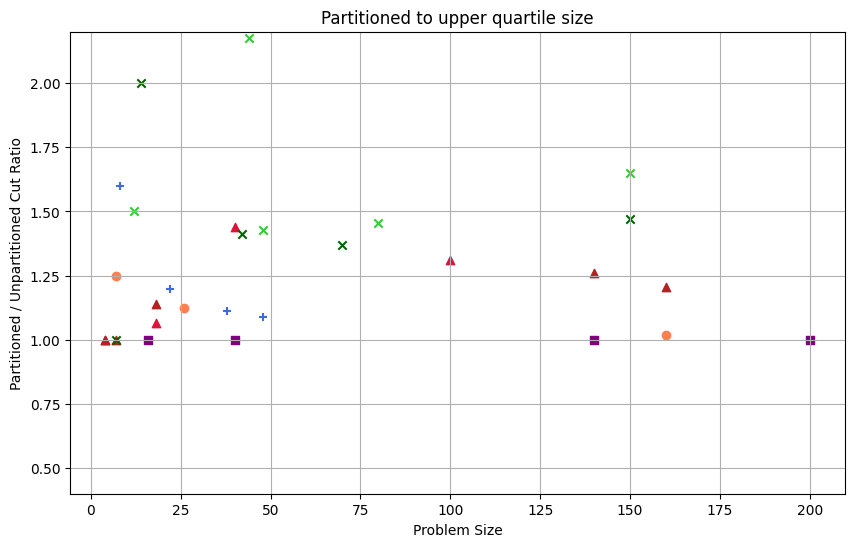

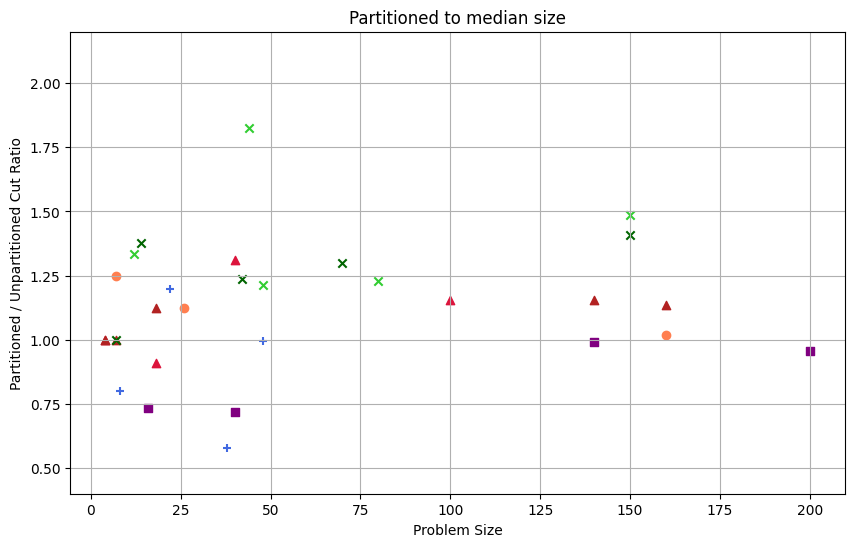

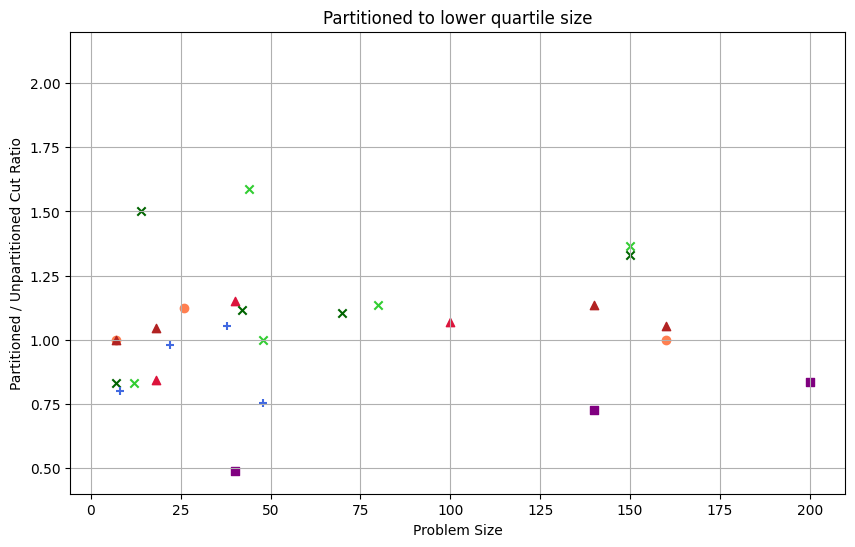

In [19]:
import matplotlib.pyplot as plt

# Create separate figures for each plot
fig1, ax1 = plt.subplots(figsize=(10, 6))  # Figure for 'Partitioned to upper quartile size'
fig2, ax2 = plt.subplots(figsize=(10, 6))  # Figure for 'Partitioned to median size'
fig3, ax3 = plt.subplots(figsize=(10, 6))  # Figure for 'Partitioned to lower quartile size'

# Plot 1 (Upper Quartile)
ax1.scatter(circ_problem_size, circ_ratio_high, label='circulant', color='coral', marker='o')
ax1.scatter(gnp_k3_problem_size, gnp_k3_ratio_high, label='gnp_k3', color='crimson', marker='^')
ax1.scatter(gnp_k5_problem_size, gnp_k5_ratio_high, label='gnp_k5', color='firebrick', marker='^')
ax1.scatter(reg_4_problem_size, reg_4_ratio_high, label='reg_4', color='limegreen', marker='x')
ax1.scatter(reg_6_problem_size, reg_6_ratio_high, label='reg_6', color='darkgreen', marker='x')
ax1.scatter(bipart_problem_size, bipart_ratio_high, label='bipart', color='royalblue', marker='+')
ax1.scatter(star_problem_size, star_ratio_high, label='star', color='purple', marker='s')
#ax1.legend(title='Graph Types')
ax1.set_ylabel('Partitioned / Unpartitioned Cut Ratio')
ax1.grid(True)
ax1.set_xlabel('Problem Size')
ax1.set_title('Partitioned to upper quartile size')
ax1.set_ylim(0.4, 2.2)

# Plot 2 (Median)
ax2.scatter(circ_problem_size, circ_ratio_mid, label='circulant', color='coral', marker='o')
ax2.scatter(gnp_k3_problem_size, gnp_k3_ratio_mid, label='gnp_k3', color='crimson', marker='^')
ax2.scatter(gnp_k5_problem_size, gnp_k5_ratio_mid, label='gnp_k5', color='firebrick', marker='^')
ax2.scatter(reg_4_problem_size, reg_4_ratio_mid, label='reg_4', color='limegreen', marker='x')
ax2.scatter(reg_6_problem_size, reg_6_ratio_mid, label='reg_6', color='darkgreen', marker='x')
ax2.scatter(bipart_problem_size, bipart_ratio_mid, label='bipart', color='royalblue', marker='+')
ax2.scatter(star_problem_size, star_ratio_mid, label='star', color='purple', marker='s')
ax2.set_ylabel('Partitioned / Unpartitioned Cut Ratio')
ax2.grid(True)
ax2.set_xlabel('Problem Size')
ax2.set_title('Partitioned to median size')
ax2.set_ylim(0.4, 2.2)

# Plot 3 (Lower Quartile)
ax3.scatter(circ_problem_size, circ_ratio_low, label='circulant', color='coral', marker='o')
ax3.scatter(gnp_k3_problem_size, gnp_k3_ratio_low, label='gnp_k3', color='crimson', marker='^')
ax3.scatter(gnp_k5_problem_size, gnp_k5_ratio_low, label='gnp_k5', color='firebrick', marker='^')
ax3.scatter(reg_4_problem_size, reg_4_ratio_low, label='reg_4', color='limegreen', marker='x')
ax3.scatter(reg_6_problem_size, reg_6_ratio_low, label='reg_6', color='darkgreen', marker='x')
ax3.scatter(bipart_problem_size, bipart_ratio_low, label='bipart', color='royalblue', marker='+')
ax3.scatter(star_problem_size, star_ratio_low, label='star', color='purple', marker='s')
ax3.set_ylabel('Partitioned / Unpartitioned Cut Ratio')
ax3.grid(True)
ax3.set_xlabel('Problem Size')
ax3.set_title('Partitioned to lower quartile size')
ax3.set_ylim(0.4, 2.2)

plt.show()

In [9]:
circ_result = {'problem_size': [130, 200, 20, 8, 6], 'gurobi_cut_sizes': [190, 298, 26, 8, 6], 'gw_cut_sizes': [180, 280, 24, 8, 6], 'cplex_cut_sizes': [194, 296, 28, 8, 8], 'part_gurobi_cut_sizes': [[182, 294, 26, 6, 8], [188, 282, 28, 10, 8], [184, 278, 28, 16, 8]], 'part_gw_cut_sizes': [[182, 294, 26, 6, 8], [188, 282, 28, 10, 8], [184, 278, 28, 16, 8]], 'part_cplex_cut_sizes': [[182, 294, 26, 6, 8], [188, 282, 28, 10, 8], [184, 278, 28, 16, 8]], 'edges_after_pruning': [0.9538461538461539, 0.9769230769230769, 1.0, 0.97, 0.985, 1.0, 0.6, 0.8, 1.0, 0.3125, 0.5, 1.0, 0.16666666666666666, 0.6666666666666666, 1.0]}
gnp_k3_result = {'problem_size': [160, 14, 18, 120, 46], 'gurobi_cut_sizes': [0, 0, 0, 0, 0], 'gw_cut_sizes': [606, 26, 37, 421, 145], 'cplex_cut_sizes': [0, 0, 0, 0, 0], 'part_gurobi_cut_sizes': [[715, 26, 45, 470, 162], [732, 24, 50, 493, 178], [774, 35, 52, 539, 189]], 'part_gw_cut_sizes': [[715, 26, 45, 470, 162], [732, 24, 50, 493, 178], [774, 35, 52, 539, 189]], 'part_cplex_cut_sizes': [[715, 26, 45, 470, 162], [732, 24, 50, 493, 178], [774, 35, 52, 539, 189]], 'edges_after_pruning': [0.27591973244147155, 0.5359531772575251, 1.0, 0.2222222222222222, 0.4222222222222222, 1.0, 0.24324324324324326, 0.5945945945945946, 1.0, 0.24580335731414868, 0.4676258992805755, 1.0, 0.3308550185873606, 0.49814126394052044, 1.0]}
gnp_k5_result = {'problem_size': [120, 200, 42, 38], 'gurobi_cut_sizes': [0, 0, 0, 0], 'gw_cut_sizes': [681, 1333, 193, 163], 'cplex_cut_sizes': [0, 0, 0, 0], 'part_gurobi_cut_sizes': [[777, 1468, 214, 196], [821, 1594, 224, 204], [860, 1614, 237, 206]], 'part_gw_cut_sizes': [[777, 1468, 214, 196], [821, 1594, 224, 204], [860, 1614, 237, 206]], 'part_cplex_cut_sizes': [[777, 1468, 214, 196], [821, 1594, 224, 204], [860, 1614, 237, 206]], 'edges_after_pruning': [0.26993416239941476, 0.5786393562545721, 1.0, 0.23453510436432637, 0.5089184060721063, 1.0, 0.26842105263157895, 0.5289473684210526, 1.0, 0.31547619047619047, 0.4851190476190476, 1.0]}
reg_4_result = {'problem_size': [160, 36, 38, 140], 'gurobi_cut_sizes': [0, 0, 0, 0], 'gw_cut_sizes': [172, 48, 38, 134], 'cplex_cut_sizes': [0, 0, 0, 0], 'part_gurobi_cut_sizes': [[200, 44, 44, 172], [230, 48, 58, 206], [268, 58, 58, 232]], 'part_gw_cut_sizes': [[200, 44, 44, 172], [230, 48, 58, 206], [268, 58, 58, 232]], 'part_cplex_cut_sizes': [[200, 44, 44, 172], [230, 48, 58, 206], [268, 58, 58, 232]], 'edges_after_pruning': [0.290625, 0.45625, 1.0, 0.25, 0.4722222222222222, 1.0, 0.25, 0.47368421052631576, 1.0, 0.29285714285714287, 0.5071428571428571, 1.0]}
reg_6_result = {'problem_size': [130, 24, 8, 14], 'gurobi_cut_sizes': [0, 0, 0, 0], 'gw_cut_sizes': [200, 40, 12, 22], 'cplex_cut_sizes': [0, 0, 0, 0], 'part_gurobi_cut_sizes': [[240, 40, 14, 24], [270, 46, 14, 28], [292, 50, 16, 32]], 'part_gw_cut_sizes': [[240, 40, 14, 24], [270, 46, 14, 28], [292, 50, 16, 32]], 'part_cplex_cut_sizes': [[240, 40, 14, 24], [270, 46, 14, 28], [292, 50, 16, 32]], 'edges_after_pruning': [0.24102564102564103, 0.5794871794871795, 1.0, 0.2222222222222222, 0.5555555555555556, 1.0, 0.20833333333333334, 0.75, 1.0, 0.30952380952380953, 0.42857142857142855, 1.0]}
bipart_result = {'problem_size': [9, 180, 36, 7, 40], 'gurobi_cut_sizes': [0, 0, 0, 0, 0], 'gw_cut_sizes': [11, 7922, 290, 6, 362], 'cplex_cut_sizes': [0, 0, 0, 0, 0], 'part_gurobi_cut_sizes': [[10, 5200, 162, 3, 248], [20, 8100, 186, 12, 224], [20, 8100, 324, 12, 400]], 'part_gw_cut_sizes': [[10, 5200, 162, 3, 248], [20, 8100, 186, 12, 224], [20, 8100, 324, 12, 400]], 'part_cplex_cut_sizes': [[10, 5200, 162, 3, 248], [20, 8100, 186, 12, 224], [20, 8100, 324, 12, 400]], 'edges_after_pruning': [0.3, 0.45, 1.0, 0.5666666666666667, 0.8022222222222222, 1.0, 0.2808641975308642, 0.5740740740740741, 1.0, 0.16666666666666666, 1.0, 1.0, 0.5825, 0.56, 1.0]}
star_result = {'problem_size': [160, 80, 36, 22, 7, 90], 'gurobi_cut_sizes': [0, 0, 0, 0, 0, 0], 'gw_cut_sizes': [159, 79, 35, 21, 6, 89], 'cplex_cut_sizes': [0, 0, 0, 0, 0, 0], 'part_gurobi_cut_sizes': [[146, 49, 30, 13, 4, 73], [156, 74, 30, 20, 6, 72], [159, 79, 35, 21, 6, 89]], 'part_gw_cut_sizes': [[146, 49, 30, 13, 4, 73], [156, 74, 30, 20, 6, 72], [159, 79, 35, 21, 6, 89]], 'part_cplex_cut_sizes': [[146, 49, 30, 13, 4, 73], [156, 74, 30, 20, 6, 72], [159, 79, 35, 21, 6, 89]], 'edges_after_pruning': [0.89937106918239, 0.9811320754716981, 1.0, 0.4810126582278481, 0.9240506329113924, 1.0, 0.8571428571428571, 0.8285714285714286, 1.0, 0.6190476190476191, 0.9523809523809523, 1.0, 0.6666666666666666, 1.0, 1.0, 0.7865168539325843, 0.7303370786516854, 1.0]}
